# Tinkering Notebook 3a: Model-free prediction

In Tinkering Notebook 2 we saw different ways to find the value function $v_\pi(s)$ given that we know the dynamics $p(s', r | s, a)$. In this notebook we will see how we can learn $v_\pi(s)$ in a model-free way using experience. 

# Table of content
* ### [1. Imports](#sec1)
* ### [2. Monte-Carlo Methods](#sec2)
 * #### [2.1 Bias and variance](#sec2_1)
 * #### [2.2 Constant step size and non-stationary case](#sec2_2)
* ### [3. Monte-Carlo Prediction](#sec3)
* ### [4. Temporal Differences Prediction (TD)](#sec4)


# 1. Imports <a id="sec1">

In [1]:
import gymnasium as gym
import gym_RLcourse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Used to clear the output of a Jupyter cell.

# 2. Monte-Carlo Methods <a id="sec2">

In this section, we will look at the example with two dice from Lecture 4. 

The main point of this section is to better understand the ideas around bias and variance and to examine the difference between a constant step size and a step size that decreases over time.

## 2.1 Bias and variance <a id="sec2_1">

We start with an example of throwing two dice and let $G$ be the sum we get from the two dice. We want to find $\mathbb{E}[ G ]$.
With hand calculations, it can be shown that $\mathbb{E}[G]=7$, but this can be pretty cumbersome to compute.  

Here, we instead carry out $N=1000$ throws with the two dice and compute the average value $V$. Remember that we can compute this incrementally using (see Lecture 4)
$$
V \leftarrow V + \frac{1}{n} ( G - V).
$$
In the code below, we also store and plot the estimated $V$ after each throw. 

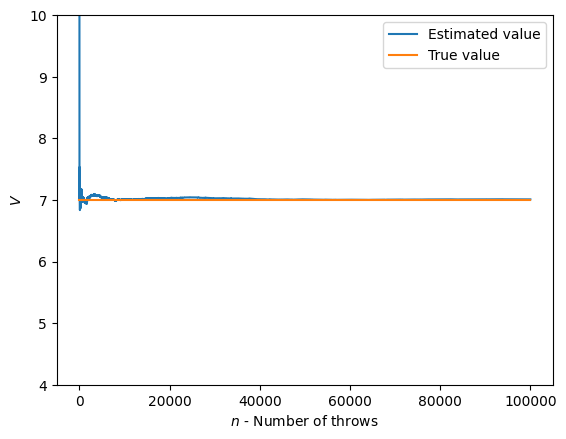

In [2]:
N = 100000 # Total number of throws
V = np.zeros(N+1) # Will be used to store the mean values

# V[0] is the initial value. (Should be zero to get true empirical mean)
# V[1] is the mean after one throw, etc.

for n in range(1,N+1):
    dice1 = np.random.randint(1, 7) # Random between 1 and 6
    dice2 = np.random.randint(1, 7) # Random between 1 and 6
    G = dice1 + dice2
    V[n] = V[n-1] + 1/n*(G-V[n-1])
    
plt.plot(range(1,N+1), V[1:], label="Estimated value")
plt.plot([1,N], [7, 7], label="True value") # True E[G]
plt.ylim([4,10])
plt.xlabel("$n$ - Number of throws")
plt.ylabel("$V$");
plt.legend();

**Task:** Re-run the code cell above a few times to see that the results are different every time. Note that the difference between each run is larger for small $n$ than large $n$.

**Task:** You can try to increase $N$ in the code above, to see that $V$ really converge to 7 as $n \rightarrow \infty$.

The reason we get different results in each run is that the observations are random, so `V[n]` is random. 

**Bias:** Tells us how much the expected value of `V[n]` differs from the true value (7). In Lecture 4 we saw that the bias in this case is 0, so `V[n]` is an unbiased estimate for all $n$. That is: If you run the code above (infinitely) many times `V[n]` will on average be 7 for all $n$.

**Variance:** Tell us how much `V[n]` will vary around the expected value if we re-run the code many times. From running the code above many times, we see that it varies more for small $n$ than for large $n$. This is consistent with the fact that the variance is $5.83/n$ (see Lecture 4) and thus decreases as $n$ increases.

**Consistency:** The estimate is consistent since $V \rightarrow \mathbb{E}[G] = 7$ as $n\rightarrow \infty$. If you let $N=100000$ or even larger, you will see that this is indeed the case for this dice example.

## 2.2 Constant step size and non-stationary case <a id="sec2_2">

The incremental update used above can be written as 
$$
V \leftarrow V + \alpha_n ( G - V)
$$
where $\alpha_n = 1/n$. These types of updates will come back over and over again in the course. 

Sometimes we will use a constant $\alpha \in (0,1)$. In this section, we will study constant $\alpha$ in the simple two-dice example.

The effect of choosing constant $\alpha$ is intuitively that we put less weight on observations that happened a long time ago. For example, with $\alpha = 1$ we get $V \leftarrow G$, i.e., we forget everything that happened before the last observation completely (see textbook Chapter 2.5 for more discussion on this).

The code below is the same as in the previous section but with a constant step size `alpha`.

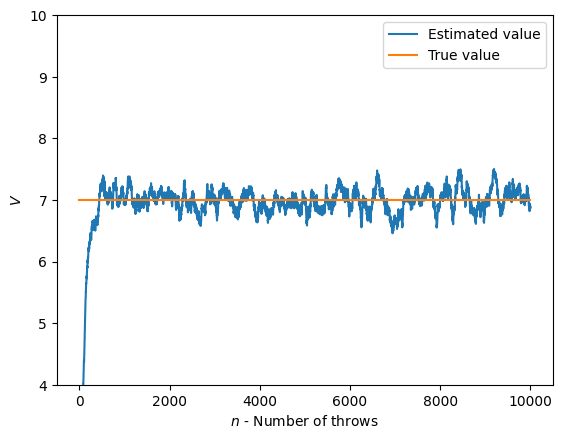

In [3]:
alpha = 0.01
N = 10000 # Total number of throws
V = np.zeros(N+1) # Will be used to store the mean values

for n in range(1,N+1):
    dice1 = np.random.randint(1, 7) # Random between 1 and 6
    dice2 = np.random.randint(1, 7) # Random between 1 and 6
    G = dice1 + dice2
    V[n] = V[n-1] + alpha*(G-V[n-1])
    
plt.plot(range(1, N+1),V[1:], label="Estimated value")
plt.plot([1,N], [7, 7], label="True value"); # True E[G]
plt.ylim([4,10])
plt.xlabel("$n$ - Number of throws")
plt.ylabel("$V$")
plt.legend();

**Task:** Vary `alpha` between 0 and 1. Try at least 0.5, 0.1, and 0.01. Also, compare the result with the previous section where we used $\alpha_n = 1/n$.

**Task:** Do the same as above, but with $N=10000$ to see if the estimate seems to converge as $n\rightarrow \infty$.

From the test above, you should be able to see that:
1. The estimate never converges to a fixed number. This is because $\alpha$ does not go to zero, and therefore, the estimate will continue to change for each new observation even as $n \rightarrow \infty$. Another view: The larger $\alpha$ is, the more we focus on just the last few observations.
2. But for large $n$, the estimate will vary around the true value.
3. Smaller step size means that it takes longer to get close to the true value, but on the other hand, it does not vary as much around the true value for large $n$.

So, to learn fast, use large $\alpha$, but to get the result as accurate as possible as $n \rightarrow \infty$ use small $\alpha$. A step-size schedule such as $\alpha_n = 1/n$ combines these insights by letting $\alpha_n$ be large for small $n$ and small for large $n$. 

But why would we ever use a constant $\alpha$ then? Some good reasons may be:
1. Easier to implement. In more advanced settings than just computing the mean value, it is not always obvious how a good step-size schedule $\alpha_n$ should look.
2. It may not be important that the estimate converge to a fixed number (just that it gets close enough to the true value).
2. If the underlying probabilities may change, it is important to continue to learn! If we let $\alpha_n \rightarrow 0$, then new observations will not matter much when $n$ is large.

In the code below, we first do `N_two = 1000` throws with two dice. After this, one dice gets lost. So, we perform `N_one = 500` throws with only one dice (so the expected value changes from 7 to 3.5 after throw 1000).

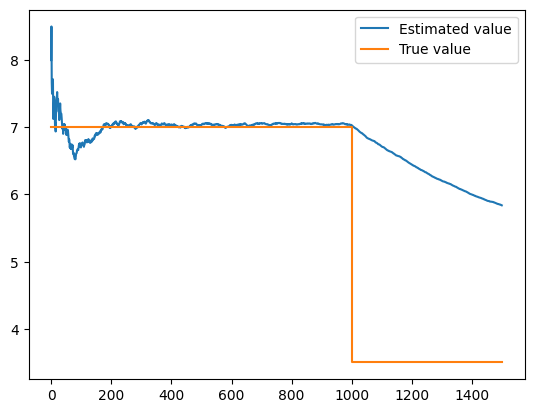

In [4]:
N_two = 1000 # Total number of throws with 2 dice
N_one = 500 # Total number of throws with 1 die
N = N_one+N_two
V = np.zeros(N+1) # Will be used to store the mean values

for n in range(1,N+1):
    if n<=N_two:
        dice1 = np.random.randint(1, 7) # Random between 1 and 6
        dice2 = np.random.randint(1, 7) # Random between 1 and 6
        G = dice1 + dice2
    else:
        G = np.random.randint(1,7)
    
    V[n] = V[n-1] + 1/n*(G-V[n-1])
    
plt.plot(V[1:], label="Estimated value")
plt.plot([1, N_two, N_two, N], [7, 7, 3.5, 3.5], label="True value")
plt.legend();

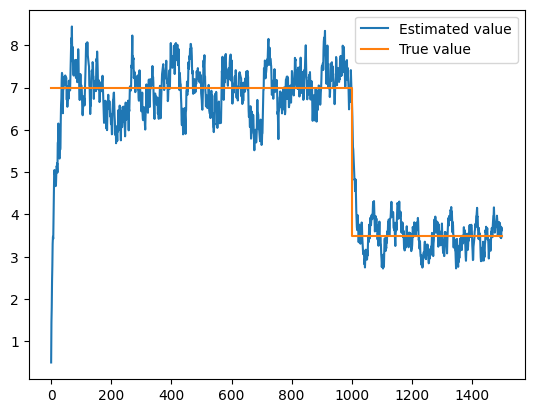

In [5]:
alpha = 0.1
N_two = 1000 # Total number of throws with 2 dice
N_one = 500 # Total number of throws with 1 die
N = N_one+N_two
V = np.zeros(N+1) # Will be used to store the mean values

for n in range(1,N+1):
    if n<=N_two:
        dice1 = np.random.randint(1, 7) # Random between 1 and 6
        dice2 = np.random.randint(1, 7) # Random between 1 and 6
        G = dice1 + dice2
    else:
        G = np.random.randint(1,7)
    
    V[n] = V[n-1] + alpha*(G-V[n-1])
    
plt.plot(V[1:], label="Estimated value")
plt.plot([1, N_two, N_two, N], [7, 7, 3.5, 3.5], label="True value")
plt.legend();

**Task:** Change the code above to use a constant step-size `alpha` instead of `1/n`. Try different values of `alpha`. (At least 0.01, 0.1 and 0.5)

It should be clear that using a constant `alpha` (where you put less weight on old observations) gives estimates that are much faster in detecting that the expected value has changed. In a real-world RL implementation, it may be important to be able to react to a change in the underlying environment (i.e., if $p(s', r | s, a)$ changes). It could be that we control a robot, but due to wear and tear, the friction between the robot and the floor changes over time.

# 3. Monte-Carlo Prediction <a id="sec3">

We will now try to find an estimate of $v_\pi(s)$ using Monte-Carlo. 

In Monte-Carlo prediction, we let the agent run a full episode with policy $\pi$ to get a trajectory
$$
S_0, R_1, S_1, R_2, S_2, R_3, \ldots, S_{T-1}, R_T, S_T
$$
where $S_T$ is a terminal state (so no future rewards are received when this state is reached). 

For each state in the trajectory, we then compute 
$$
G_t = R_{t+1} + \gamma R_{t+2} + \cdots + \gamma^{T-t-1} R_T.
$$
Note that if we start from the end of the episode and go backward, we can use the recursive relationship
$$
G_t = \begin{cases}
0 & \text{if } t = T \\
R_{t+1} + \gamma G_{t+1}  &\text{if } t<T
\end{cases}
$$
Finally we incrementally update the estimate $V(S_t)$ using 
$$
V(S_t) \leftarrow  V(S_t) + \frac{1}{N(S_t)} (G_t - V(S_t))
$$
where $N(S_t)$ is the number of times we have updated the state $S_t$. 

Below we implement the every-visit version of the MC-algorithm. Make sure that you understand the code. To change it to the first-visit version, you must add code so that you only update $V(S_t)$ if $t$ is the first time you are in state $S_t$.

In [31]:
class MCAgent():
    
    def __init__(self, n_states, n_actions, gamma):
        self.n_actions = n_actions
        self.V = np.zeros(n_states)
        self.N = np.zeros(n_states)
        self.gamma = gamma
        
    def act(self, state):
        # Use a uniform random policy (all actions have equal probability)
        return np.random.choice(self.n_actions)
    
    def learn(self, states, rewards):
        T = len(states)
        G = 0 # G_T = 0
        
        for t in reversed(range(T)): # From T-1 to 0
            G = rewards[t+1] + self.gamma*G # G_t = R_{t+1} + gamma*G_{t+1}
            
            self.N[states[t]] += 1
            #self.V[states[t]] += 1/self.N[states[t]] * (G - self.V[states[t]])
            self.V[states[t]] += 0.01 * (G - self.V[states[t]])

To test our implementation, we use the `GymGrid-v0` environment also studied in Tinkering Notebook 2. With a uniform random policy and discount $\gamma = 1$, we know that the state-value function for this environment will be 

In [32]:
value_function = np.array([ [0.,   -14., -20., -22.],
                            [-14., -18., -20., -20.],
                            [-20., -20., -18., -14.],
                            [-22., -20., -14., 0.] ]).ravel() 
# ravel turn value_function into a flat array. To write it as a matrix, use reshape.
print(value_function.reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


To try out the MC algorithm, we run 1000 episodes using the uniform random policy implemented in `agent.act`. After each episode, we use `agent.learn` to update our current estimate of the state-value function. We also keep track of the maximum absolute error in the estimate (which we can compute since we, in this case, know the true value function).

We also save the estimated values' history to see how the value in different states converges.

In [33]:
n_episodes = 10000

env = gym.make('GridWorld-v0') # the same as in Example 3.5
agent = MCAgent(env.observation_space.n, env.action_space.n, gamma=1)

error = np.zeros(n_episodes)
values = np.zeros((n_episodes, env.observation_space.n))

for i in range(n_episodes):
    state, info = env.reset()
    states = []
    rewards = [0] # rewards[0] is not used in MC, so you can set it to anything
    terminated = False
    truncated = False
    while not terminated and not truncated: # Run one episode with the agent's policy
        states.append(state) # Add state to the list of states seen
        action = agent.act(state) 
        state, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward) # Add reward to list of rewards seen
        
    agent.learn(states, rewards) # Update value function
    values[i,:] = agent.V
    # Maximum difference between true and estimated value function:
    error[i] = np.max(np.abs(agent.V - value_function))

We first plot the maximum absolute error after each episode.

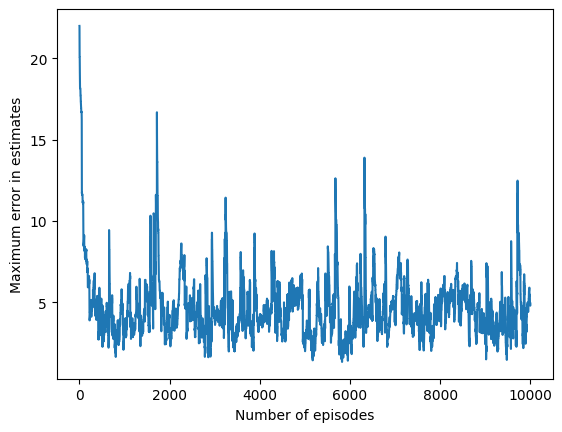

In [34]:
plt.plot(error)
plt.ylabel('Maximum error in estimates')
plt.xlabel('Number of episodes');

And then we plot the estimated value of state `s` after each episode. You can change `s` to look at different states.

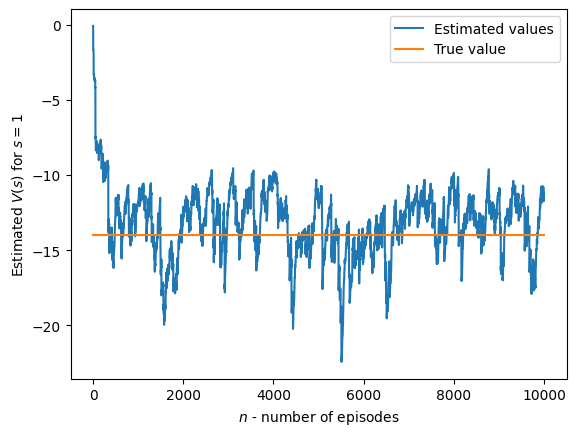

In [35]:
s = 1
# Plot estimated value in state s
plt.plot(values[:,s], label='Estimated values')

# Plot true value in state s
plt.plot([0, n_episodes], [value_function[s], value_function[s]], label='True value')

plt.xlabel('$n$ - number of episodes')
plt.ylabel("Estimated $V(s)$ for $s={}$".format({s}));
plt.legend()

### Tasks:
1. Increase the number of episodes (e.g. to 10,000) you use in training and see if you get better estimates.

2. Try running the MC method with a constant step size. (You have to change the code in `MCAgent` and remember to execute the code cell again when you have made your changes.)

3. (*) Write a first-visit version of `MCAgent` and try it with the code above.

# 4. Temporal Differences Prediction (TD) <a id="sec4">

We now implement an agent that learns using TD. A benefit of using TD is that we do not have to wait until the end of an episode to do the updates. 

**Task:** Implement the TD-update in the `learn`-method of `TDAgent`. Use a constant step-size `alpha`.

In [16]:
class TDAgent():
    
    def __init__(self, n_states, n_actions, gamma, alpha):
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.V = np.zeros(n_states)
        
    def act(self, state):
        # Random
        return np.random.choice(self.n_actions)
    
    def learn(self, state, action, reward, state_next):
        self.V[state] += self.alpha * (reward + self.gamma * self.V[state_next] - self.V[state])

We will again test our agent on the `GridWorld-v0` with a uniform policy and discount $\gamma = 1$, so the true value function is 

In [17]:
value_function = np.array([ [0.,   -14., -20., -22.],
                            [-14., -18., -20., -20.],
                            [-20., -20., -18., -14.],
                            [-22., -20., -14., 0.] ]).ravel() 
# ravel turn value_function into a flat array. To write it as a matrix, use reshape.
print(value_function.reshape(4,4))

[[  0. -14. -20. -22.]
 [-14. -18. -20. -20.]
 [-20. -20. -18. -14.]
 [-22. -20. -14.   0.]]


The code below runs 10,000 episodes. Note that we have moved the `learn` inside the `while`-loop since we do not have to wait for the episode to end. This also makes it possible to use the TD method in continuing environments (that never terminates).

In [28]:
n_episodes = 10000
s = 5 # The state we save the history for
error = np.zeros(n_episodes)
values = np.zeros((n_episodes, env.observation_space.n))

env = gym.make('GridWorld-v0') # the same as in Example 3.5
agent = TDAgent(env.observation_space.n, env.action_space.n, alpha=0.01, gamma=1)

for i in range(n_episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        action = agent.act(state)
        state_next, reward, terminated, truncated, info = env.step(action)
        agent.learn(state, action, reward, state_next)
        state = state_next
        
    error[i] = np.max(np.abs(agent.V - value_function))
    values[i, :] = agent.V

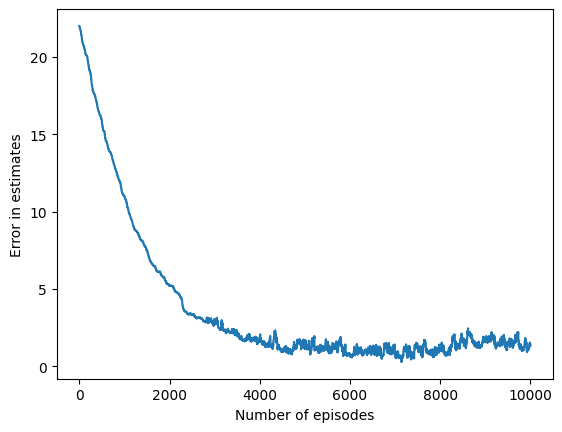

In [29]:
plt.plot(error)
plt.ylabel('Error in estimates')
plt.xlabel('Number of episodes');

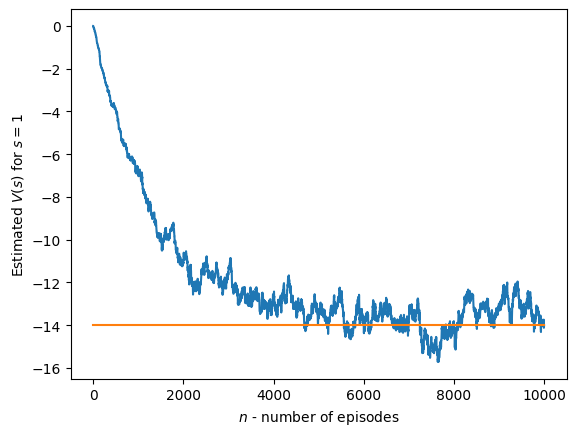

In [30]:
s = 1
plt.plot(values[:, s])
plt.plot([0, n_episodes], [value_function[s], value_function[s]])
plt.xlabel('$n$ - number of episodes')
plt.ylabel("Estimated $V(s)$ for $s={}$".format({s}));

### Task:
1. Try different step sizes `alpha`. Try to explain the difference between the results for different `alpha`. 
2. In the book it is stated that TD will have a lower variance than MC. Can you see this in your results? 

Note: Variance here refers to how much your results will vary if you re-run the experiment from scratch many times. If you compare the TD method with the MC method, you will note that the results from TD look similar each time you re-run the code above, but for MC the result will, especially for small $n$, be quite different each time. 

However, we can also see that using the TD method, on a single experiment, the estimate continues to vary when $n$ increases. This is because we use a constant step length $\alpha$, so the result does not converge to a final value. (See the discussion about the dice example at the beginning of the notebook). You will see the same effect in the MC method if you use a constant step size.